In [1]:
import torch
from torch import nn
from load_mnist import load_mnist
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

## 1.1

In [2]:
def training_curve_plot(title, train_losses, test_losses, train_accuracy, test_accuracy):
    """ 
    convenience function for plotting train and test loss and accuracy
    """
    lg=13
    md=10
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, fontsize=lg)
    x = range(1, len(train_losses)+1)
    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, test_losses, label=f'Final test loss: {test_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {train_accuracy[-1]:.4f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {test_accuracy[-1]:.4f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Iteration', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

In [3]:
#Network architecture
# Implement a 2-layer neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
       
        return out

In [4]:


#Load MNIST dataset
x_train, y_train, x_test, y_test = load_mnist()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_set = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_set = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


In [5]:
def train_network(model: nn.Module, criteria: nn.Module, 
                  optimizer: torch.optim.Optimizer, num_epochs: int, train_loader: torch.utils.data.DataLoader, 
                  test_loader: torch.utils.data.DataLoader, device: torch.device):
    """
    Train a neural network model
    
    Args:
        model: The neural network model to be trained
        criteria: The loss function
        optimizer: The optimizer
        num_epochs: The number of epochs to train the model
        train_loader: The training data loader
        test_loader: The test data loader
        device: The device to run the model on
    """
    train_costs = []
    test_costs = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
        
            
            outputs = model(images)
            loss = criteria(outputs, torch.argmax(labels, dim=1))
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
        train_costs.append(train_loss / len(train_loader))
        train_accuracy.append(100 * correct / total)
    
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criteria(outputs, torch.argmax(labels, dim=1))
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
            
            test_costs.append(test_loss / len(test_loader))
            test_accuracy.append(100 * correct / total)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_costs[-1]:.4f}, Test Loss: {test_costs[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}%, Test Accuracy: {test_accuracy[-1]:.4f}%')
    
    training_curve_plot('2-layer Neural Network', train_costs, test_costs, train_accuracy, test_accuracy)

            
    

In [6]:
#Hyperparameters
input_size = 28*28
hidden_size_1 = 512
hidden_size_2 = 256
num_classes = 10
num_epochs = 100
learning_rate = 0.01

Epoch 1/100, Train Loss: 1.6000, Test Loss: 0.6977, Train Accuracy: 64.0767%, Test Accuracy: 82.8400%
Epoch 2/100, Train Loss: 0.5262, Test Loss: 0.4065, Train Accuracy: 85.8450%, Test Accuracy: 88.8900%
Epoch 3/100, Train Loss: 0.3856, Test Loss: 0.3410, Train Accuracy: 89.2017%, Test Accuracy: 90.3000%
Epoch 4/100, Train Loss: 0.3364, Test Loss: 0.3054, Train Accuracy: 90.3667%, Test Accuracy: 91.2400%
Epoch 5/100, Train Loss: 0.3063, Test Loss: 0.2874, Train Accuracy: 91.1950%, Test Accuracy: 91.8600%
Epoch 6/100, Train Loss: 0.2841, Test Loss: 0.2664, Train Accuracy: 91.9317%, Test Accuracy: 92.5500%
Epoch 7/100, Train Loss: 0.2652, Test Loss: 0.2498, Train Accuracy: 92.3983%, Test Accuracy: 93.1300%
Epoch 8/100, Train Loss: 0.2485, Test Loss: 0.2368, Train Accuracy: 92.8717%, Test Accuracy: 93.4000%
Epoch 9/100, Train Loss: 0.2335, Test Loss: 0.2285, Train Accuracy: 93.3767%, Test Accuracy: 93.6400%
Epoch 10/100, Train Loss: 0.2197, Test Loss: 0.2115, Train Accuracy: 93.6967%, Tes

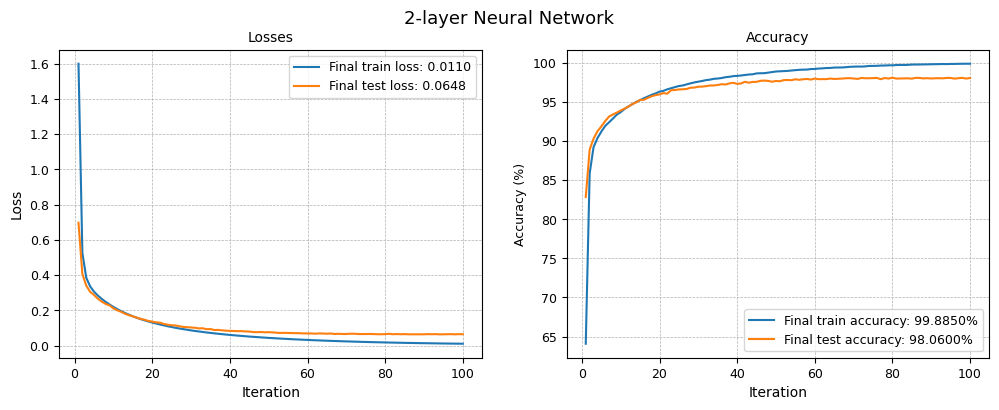

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_network(model, criteria, optimizer, num_epochs, train_loader, test_loader, device)